In [1]:
'''Section with all necessary imports'''
!pip install graphviz

In [2]:
# IMPORT SECTION
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import ipaddress
from ipaddress import ip_network
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import shap


c:\Users\pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# path to the version 1.0 of the provided data
version10 = "output_ml_students.zip"  
# path to the version 1.1 of the provided data
version11 = "output_ml_students_twosets.zip"

def my_read_fn(label):
    mapping = {
        "backend_prop": (version10, "backend_assetproperty.csv"),
        "backend_relservicemetric": (version10, "backend_assetrelationshipservicemetric.csv"),  
        "backend_relservices": (version10,"backend_assetrelationshipservice.csv"),
        "backend_relations": (version10,"backend_assetrelationship.csv"),
        "backend_types": (version10,"backend_assettype.csv"),
        "backend_asset": (version10,"backend_asset.csv"),
        "swiss_prop": (version11, "swisstools_asset_properties.csv"),
        "swiss_relservice_metrics": (version11, "swisstools_asset_relationship_service_metrics.csv"),
        "swiss_relservices": (version11, "swisstools_asset_relationship_services.csv"),
        "swiss_relations": (version11, "swisstools_asset_relationships.csv"),
        "swiss_types": (version11, "swisstools_asset_types.csv"),
        "swiss_asset": (version11, "swisstools_assets.csv"),
    }

    arch, filename = mapping[label]

    with zipfile.ZipFile(arch, 'r') as z:
        file_list = z.namelist()
        def find_file(target):
            return next((f for f in file_list if f.endswith(target)), None)

        file_in_zip = find_file(filename)
        if not file_in_zip:
            raise FileNotFoundError(f"{filename} not found in {arch}")

        return pd.read_csv(z.open(file_in_zip), low_memory=False)

backend_prop = my_read_fn("backend_prop")
backend_relservicemetric = my_read_fn("backend_relservicemetric")
backend_relservices = my_read_fn("backend_relservices")
backend_relations = my_read_fn("backend_relations")
backend_types = my_read_fn("backend_types")
backend_asset = my_read_fn("backend_asset")
swiss_prop = my_read_fn("swiss_prop")
swiss_relservice_metrics = my_read_fn("swiss_relservice_metrics")
swiss_relservices = my_read_fn("swiss_relservices")
swiss_relations = my_read_fn("swiss_relations")
swiss_types = my_read_fn("swiss_types")
swiss_asset = my_read_fn("swiss_asset")

In [4]:
def network_to_int(ip):
        """
        Convert IP address string to an integer.

        Parameters:
            ip (str): The IP address in string format (e.g., '192.168.1.0/24').

        Returns:
            int or None: The integer representation of the network address, or None if conversion fails.
        """
        try:
            return int(ip_network(ip, strict=False).network_address)
        except:
            return None

def mac_to_int(mac):
        """
        Convert MAC address to an integer by removing delimiters.

        Parameters:
            mac (str): The MAC address in string format (e.g., '00:1A:2B:3C:4D:5E' or '00-1A-2B-3C-4D-5E').

        Returns:
            int or None: The integer representation of the MAC address, or None if conversion fails.
    
        """
        try:
            return int(mac.replace(":", "").replace("-", "").lower(), 16)
        except:
            return None
def extract_first_vlan(vlan_str):
        """
        Extract the first VLAN ID from a string of comma-separated VLANs.
        
        Parameters:
            vlan_str (str): A string representing VLAN IDs (e.g., {2011}, or '{100,200,300}').

        Returns:
            int or None: The first VLAN ID as an integer, 0 if input is empty, or None if extraction fails.
        """
        
        try:
            if pd.isna(vlan_str) or vlan_str.strip('{}').strip() == '':
                return 0
            return int(vlan_str.strip('{}').split(',')[0].strip())
        except:
            return None
label_encoder = LabelEncoder()
# Drop unnecessary columns from Swiss asset dataset
swiss_asset=swiss_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
# Remove rows with missing asset_type_id (critical for joins)
swiss_asset = swiss_asset.dropna(subset=['asset_type_id'])
# Map 'processing_state' to a binary flag
swiss_asset['processing_state_binary'] = swiss_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
swiss_asset=swiss_asset.drop(columns=['processing_state'])
# Convert IP/MAC/VLAN features to integers
swiss_asset['ipaddress'] = swiss_asset['ipaddress'].apply(network_to_int)
swiss_asset['mac_address'] = swiss_asset['mac_address'].apply(mac_to_int)
swiss_asset['vlan_ids'] = swiss_asset['vlan_ids'].apply(extract_first_vlan)
# Calculate device age
swiss_asset['date_created'] = pd.to_datetime(swiss_asset['date_created'],utc=True).dt.tz_convert('UTC')
swiss_asset['date_updated'] = pd.to_datetime(swiss_asset['date_updated'],utc=True).dt.tz_convert('UTC')
swiss_asset['device_age_days'] = (swiss_asset['date_updated'] - swiss_asset['date_created']).dt.days
swiss_asset = swiss_asset.drop(columns=['date_created','date_updated','last_reported'])
swiss_types = swiss_types.dropna(subset='category')
swiss_types = swiss_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
# Clean and encode properties
swiss_prop['key'] = swiss_prop['key'].str.replace('^snmp_', '', regex=True)
swiss_prop['key'] = swiss_prop['key'].str.split('.').apply(lambda x: [int(i) for i in x if i != ''])
swiss_prop['key'] = swiss_prop['key'].apply(lambda x: int(''.join(map(str, x))))
swiss_prop["value"] = swiss_prop["value"].map(swiss_prop["value"].value_counts())
swiss_prop = swiss_prop.drop(columns=['date_created','date_updated','display_name'])
swiss_relations = swiss_relations.drop(columns=['id','date_created','date_updated','tags'])
swiss_relservices = swiss_relservices.drop(columns=['date_created','date_updated'])
swiss_relservice_metrics=swiss_relservice_metrics.drop(columns=['key','attributes','date_created','date_updated'])
# The same preprocessing was applied to Backend Dataset
backend_asset=backend_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
backend_asset = backend_asset.dropna(subset=['asset_type_id'])
backend_asset['processing_state_binary'] = backend_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
backend_asset=backend_asset.drop(columns=['processing_state'])
backend_asset['ipaddress'] = backend_asset['ipaddress'].apply(network_to_int)
backend_asset['mac_address'] = backend_asset['mac_address'].apply(mac_to_int)
backend_asset['vlan_ids'] = backend_asset['vlan_ids'].apply(extract_first_vlan)
backend_asset['date_created'] = pd.to_datetime(backend_asset['date_created'],utc=True).dt.tz_convert('UTC')
backend_asset['date_updated'] = pd.to_datetime(backend_asset['date_updated'],utc=True).dt.tz_convert('UTC')
backend_asset['device_age_days'] = (backend_asset['date_updated'] - backend_asset['date_created']).dt.days
backend_asset.drop(columns=['date_created','date_updated','last_reported'])
backend_types = backend_types.dropna(subset='category')
backend_types = backend_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
backend_prop['key'] = 0
backend_prop["value"] = backend_prop["value"].map(backend_prop["value"].value_counts())
backend_prop = backend_prop.drop(columns=['date_created','date_updated','display_name'])
backend_relations = backend_relations.drop(columns=['id','date_created','date_updated','tags'])
backend_relservices = backend_relservices.drop(columns=['date_created','date_updated'])
backend_relservicemetric = backend_relservicemetric.drop(columns=['key','attributes','date_created','date_updated'])
# MERGING SWISS NETWORK DATA
df = swiss_asset.merge(swiss_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
df = df.drop(columns=['id_type'])
df = df.merge(swiss_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
df['value'] = df['value'].fillna(0)
source_counts = swiss_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = swiss_relations['target_asset_id'].value_counts().rename('target_count')
df['source_count'] =df['id'].map(source_counts).fillna(0).astype(int)
df['target_count'] =df['id'].map(target_counts).fillna(0).astype(int)
df = df.drop(columns=['asset_id','id_prop'])
child_counts = df['parent_asset_id'].value_counts().rename('child_count')
df['child_count'] = df['id'].map(child_counts).fillna(0).astype(int)
df['has_parent'] = df['parent_asset_id'].notna().astype(int)
vendor_counts = df['vendor'].value_counts()
df['vendor'] = df['vendor'].map(vendor_counts)
# MERGING BACKEND NETWORK DATA
dff = backend_asset.merge(backend_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
dff = dff.drop(columns=['id_type'])
dff = dff.merge(backend_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
dff['value'] = dff['value'].fillna(0)
dff = dff.dropna(subset=['category'])
dff = dff[dff['category'] != 0]
source_counts = backend_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = backend_relations['target_asset_id'].value_counts().rename('target_count')
dff['source_count'] =dff['id'].map(source_counts).fillna(0).astype(int)
dff['target_count'] =dff['id'].map(target_counts).fillna(0).astype(int)
dff = dff.drop(columns=['id_prop','asset_id'])
child_counts = dff['parent_asset_id'].value_counts().rename('child_count')
dff['child_count'] = dff['id'].map(child_counts).fillna(0).astype(int)
dff['has_parent'] = dff['parent_asset_id'].notna().astype(int)
vendor_counts = dff['vendor'].value_counts()
dff['vendor'] = dff['vendor'].map(vendor_counts)

In [5]:
'''Swiss data prepartion for training'''
data = df.drop(columns=['parent_asset_id','id','asset_type_id']).fillna(0)
#data_ = data
# Encoding categories into integers
data['category_encoded'] = label_encoder.fit_transform(df['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

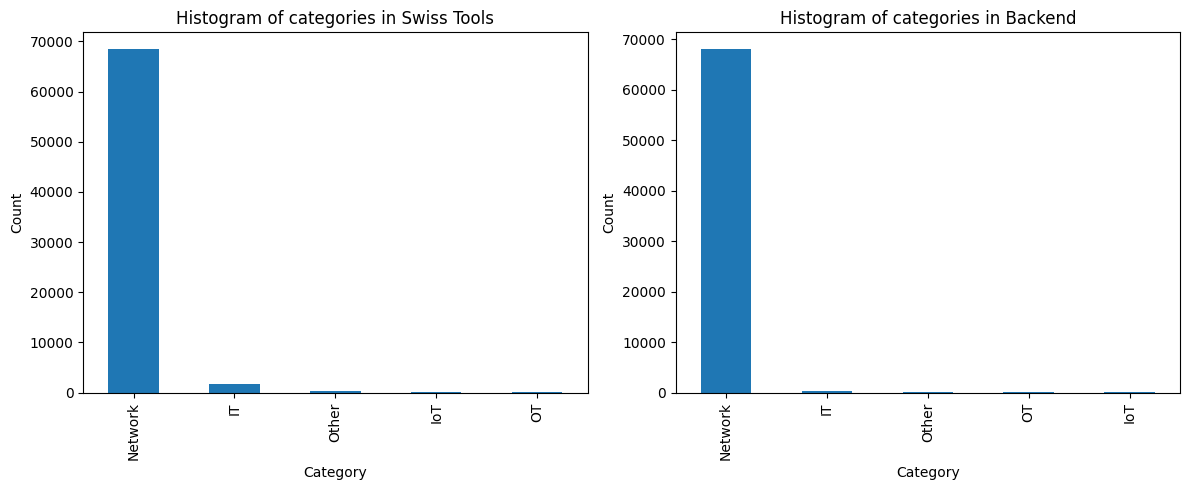

In [6]:
plt.figure(figsize=(12, 5))
# Histogram for categories in Swiss Tools
plt.subplot(1, 2, 1)
data['category'].value_counts().plot(kind='bar')
plt.title('Histogram of categories in Swiss Tools')
plt.xlabel('Category')
plt.ylabel('Count')
# Histogram for categories in Backend
plt.subplot(1, 2, 2)
dff['category'].value_counts().plot(kind='bar')
plt.title('Histogram of categories in Backend')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [7]:
'''Train/test split for training (Swiss Tools)'''
data = data.drop(columns=['category'])
X = data.drop(columns=['category_encoded'])
y = data['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X.columns

In [8]:
'''Backend Network data split into target and features'''
foreign = dff.drop(columns=['parent_asset_id','id','asset_type_id','last_reported','parent_asset_id','date_created','date_updated']).fillna(0)
label_encoder = LabelEncoder()
foreign['category_encoded'] = label_encoder.fit_transform(foreign['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
foreign = foreign.drop(columns=['category'])
X_foreign = foreign.drop(columns=['category_encoded'])
y_foreign = foreign['category_encoded']
#X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#feature_names = X.columns

#BASIC DECISION TREE


              precision    recall  f1-score   support

          IT       0.99      0.99      0.99       351
         IoT       0.94      1.00      0.97        47
     Network       1.00      1.00      1.00     13683
          OT       0.60      0.75      0.67         4
       Other       0.98      0.89      0.94        57

    accuracy                           1.00     14142
   macro avg       0.90      0.93      0.91     14142
weighted avg       1.00      1.00      1.00     14142



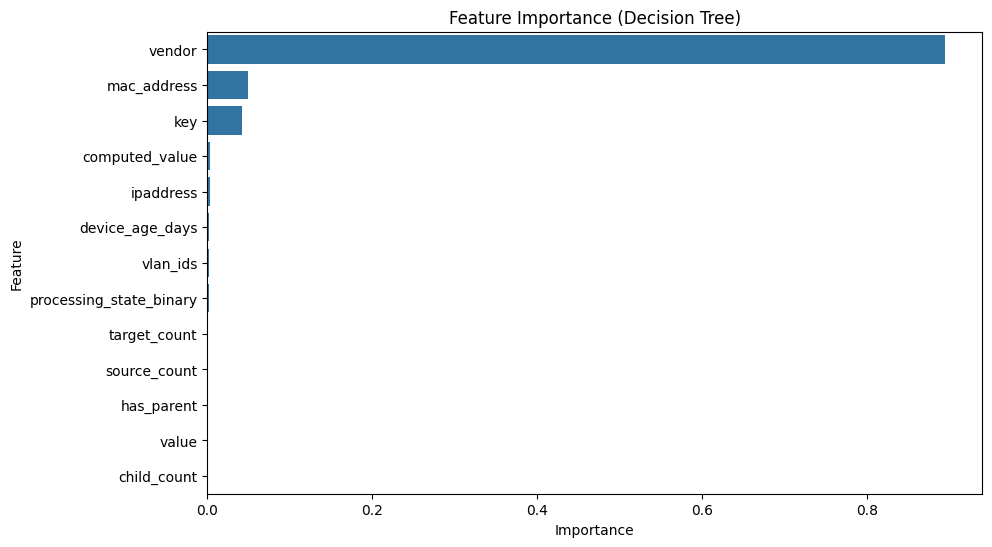

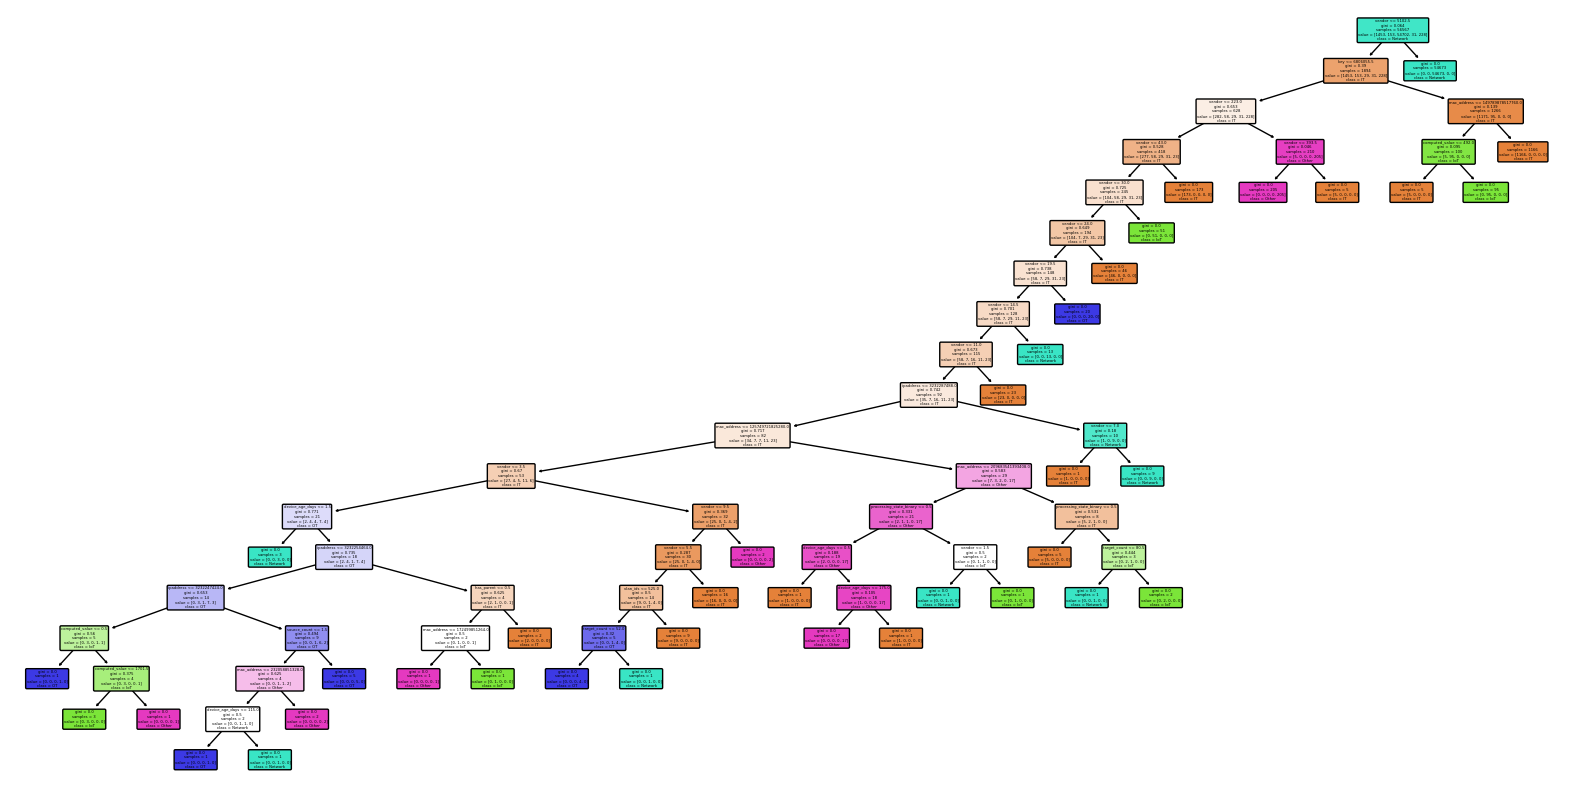

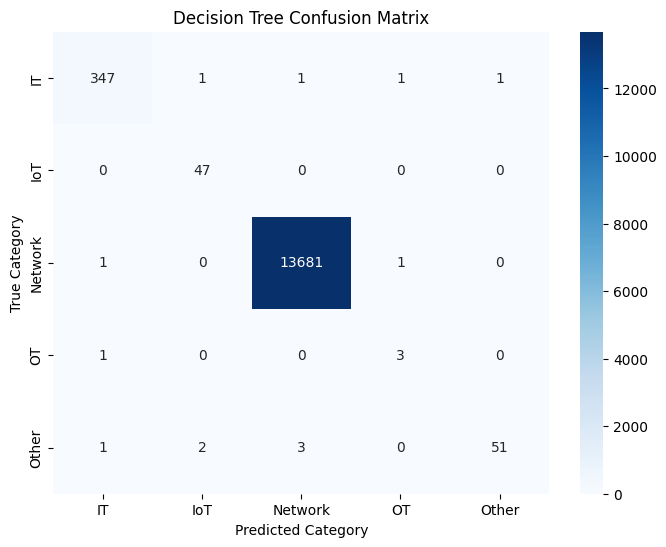

In [9]:
# BASIC DECISION TREE
tree = DecisionTreeClassifier( random_state=42)
tree.fit(X_train, y_train)
#RESULTS BASIC DECISION TREE
y_pred_tree = tree.predict(X_test)
basic_decision_tree = classification_report(y_test, y_pred_tree, target_names=label_encoder.classes_)
print(basic_decision_tree)
# Feature Importance - Decision Tree
feature_importances_tree = tree.feature_importances_
importance_df_tree = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_tree})
importance_df_tree = importance_df_tree.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_tree)
plt.title('Feature Importance (Decision Tree)')
plt.show()

#Whole Tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=label_encoder.classes_, rounded=True)
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Decision Tree Confusion Matrix")
plt.show()

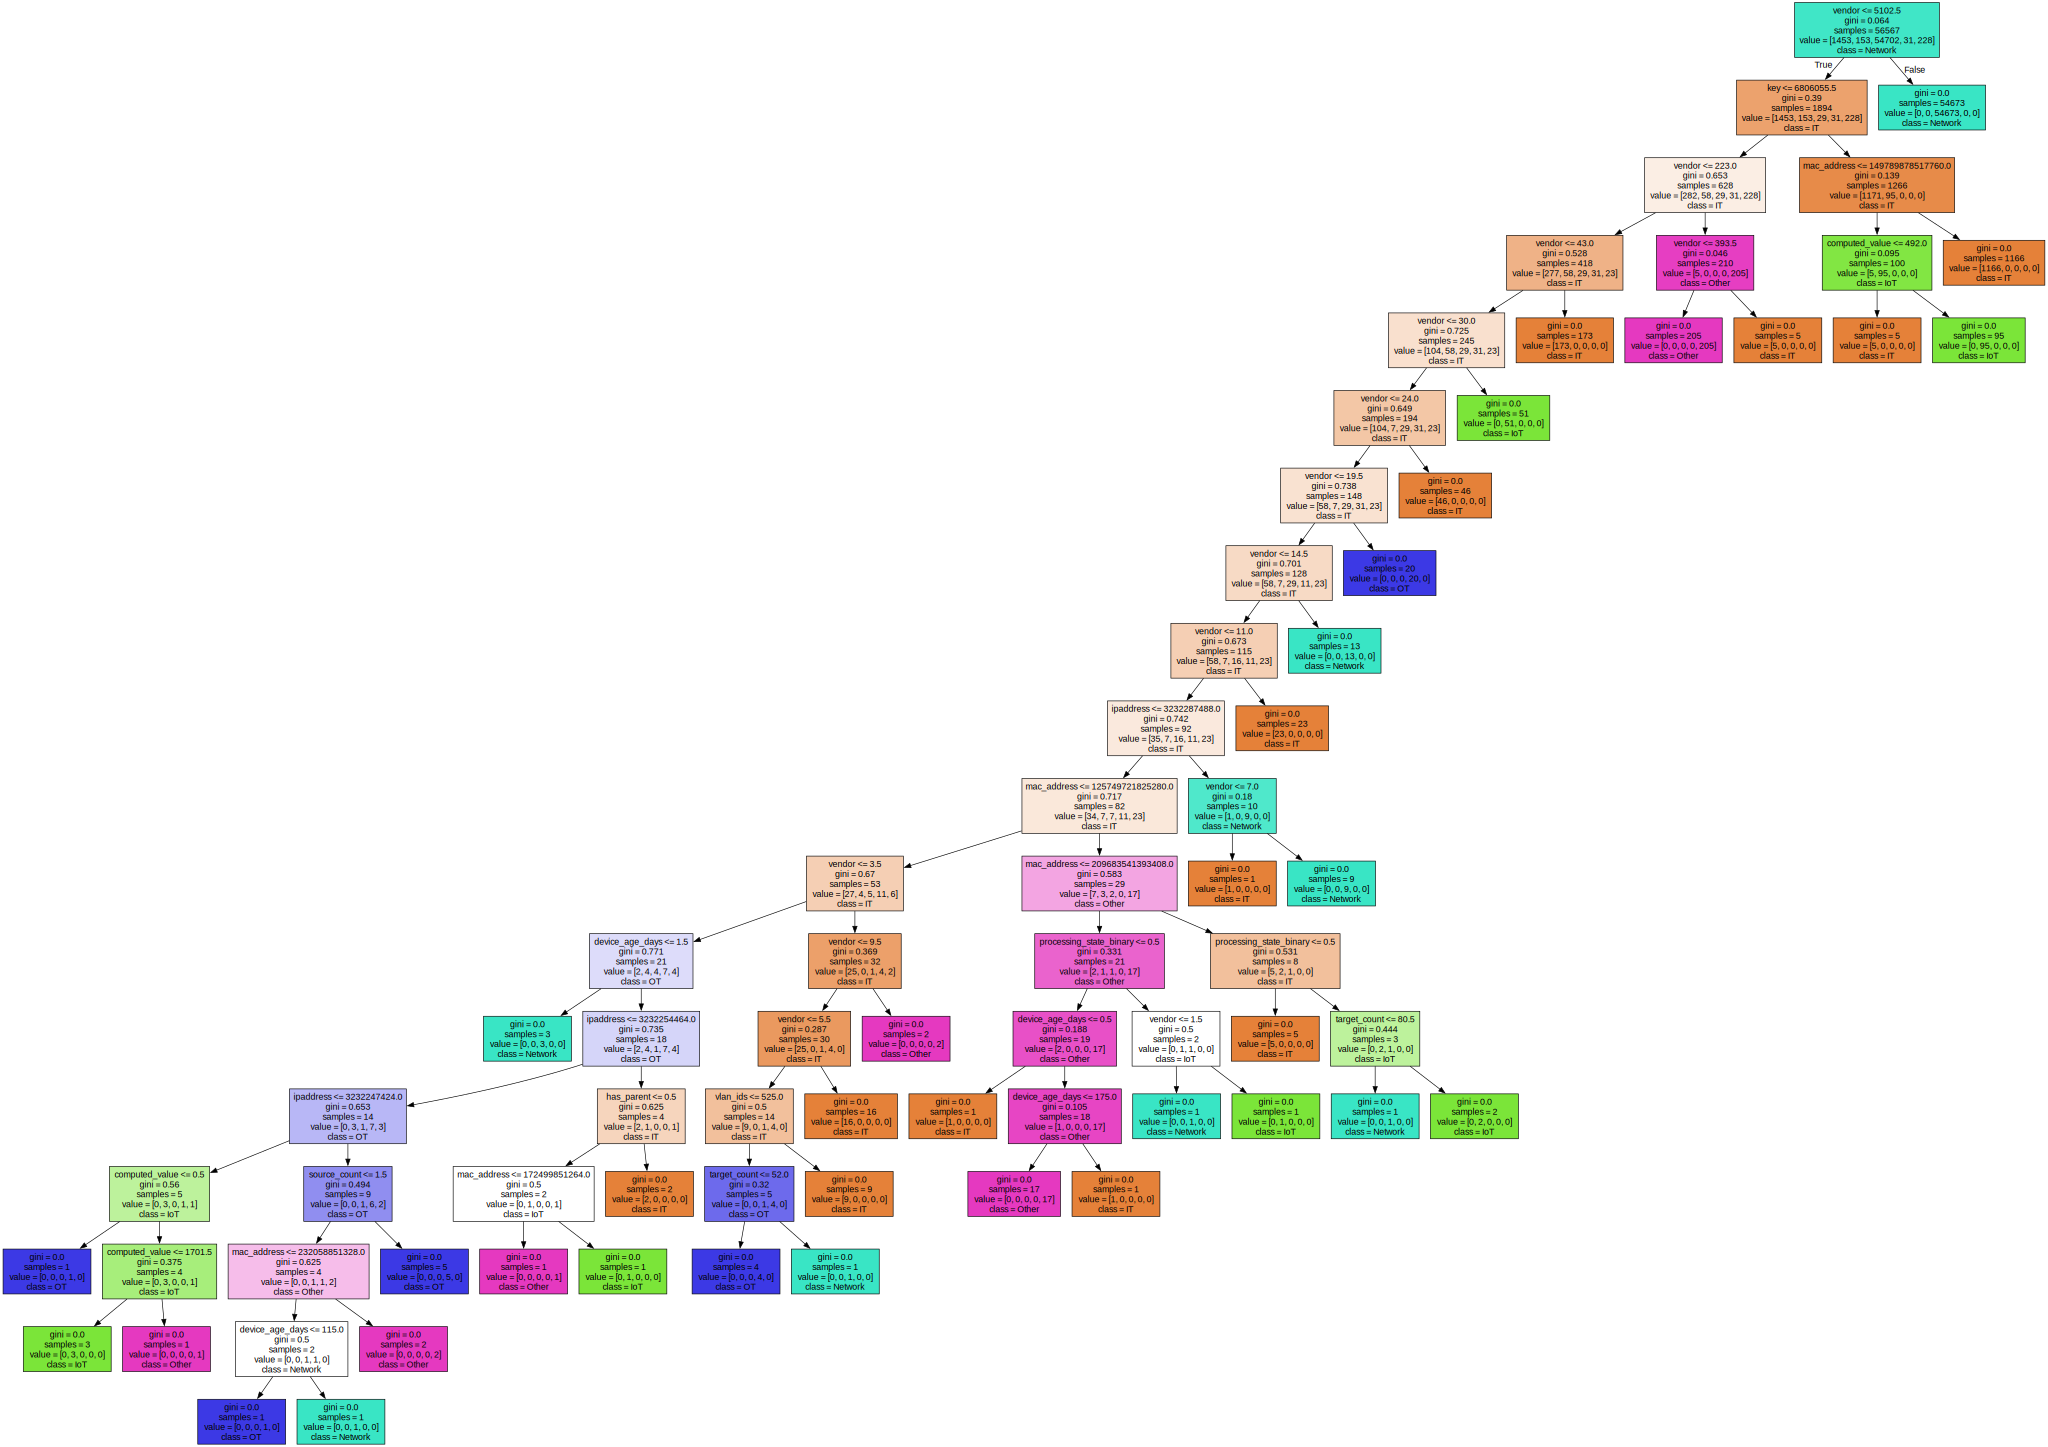

In [10]:
# Scrollable visualization of the tree
export_graphviz(tree,
                out_file="tree.dot",
                feature_names=X.columns,
                class_names=label_encoder.classes_,
                filled=True)
from graphviz import Source

with open("tree.dot") as f:
    dot_graph = f.read()

Source(dot_graph)

In [11]:
# Performance of a Basic Decision Tree on Backend Network
pred_foreign = tree.predict(X_foreign)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.48      0.57      0.52       270
         IoT       0.02      0.06      0.03        33
     Network       1.00      1.00      1.00     68015
          OT       0.11      0.12      0.11        52
       Other       0.26      0.08      0.12       192

    accuracy                           0.99     68562
   macro avg       0.37      0.36      0.36     68562
weighted avg       0.99      0.99      0.99     68562



# GRIDSEARCHCV DECISION TREE

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: 0.9993989544083351
              precision    recall  f1-score   support

          IT       0.99      0.99      0.99       351
         IoT       0.90      1.00      0.95        47
     Network       1.00      1.00      1.00     13683
          OT       0.43      0.75      0.55         4
       Other       1.00      0.88      0.93        57

    accuracy                           1.00     14142
   macro avg       0.86      0.92      0.88     14142
weighted avg       1.00      1.00      1.00     14142



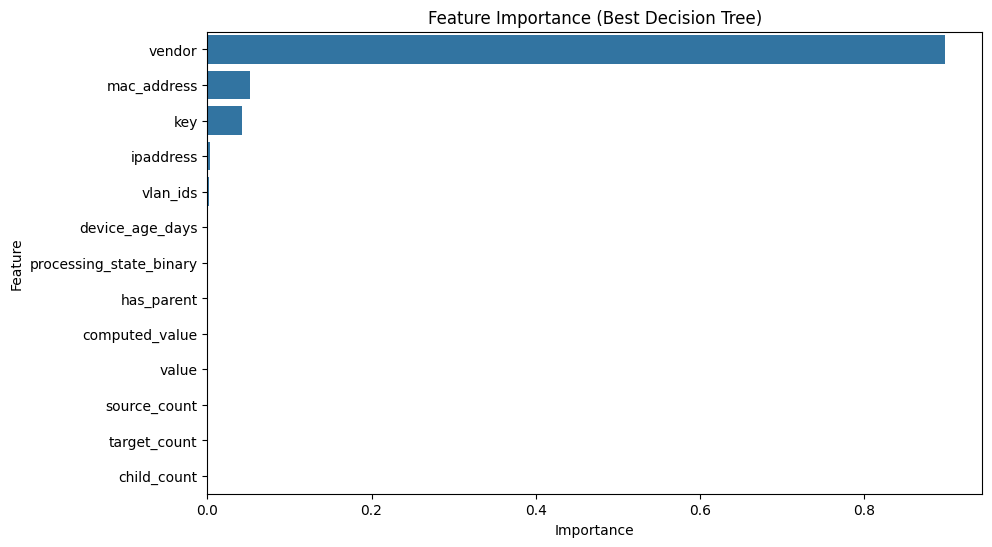

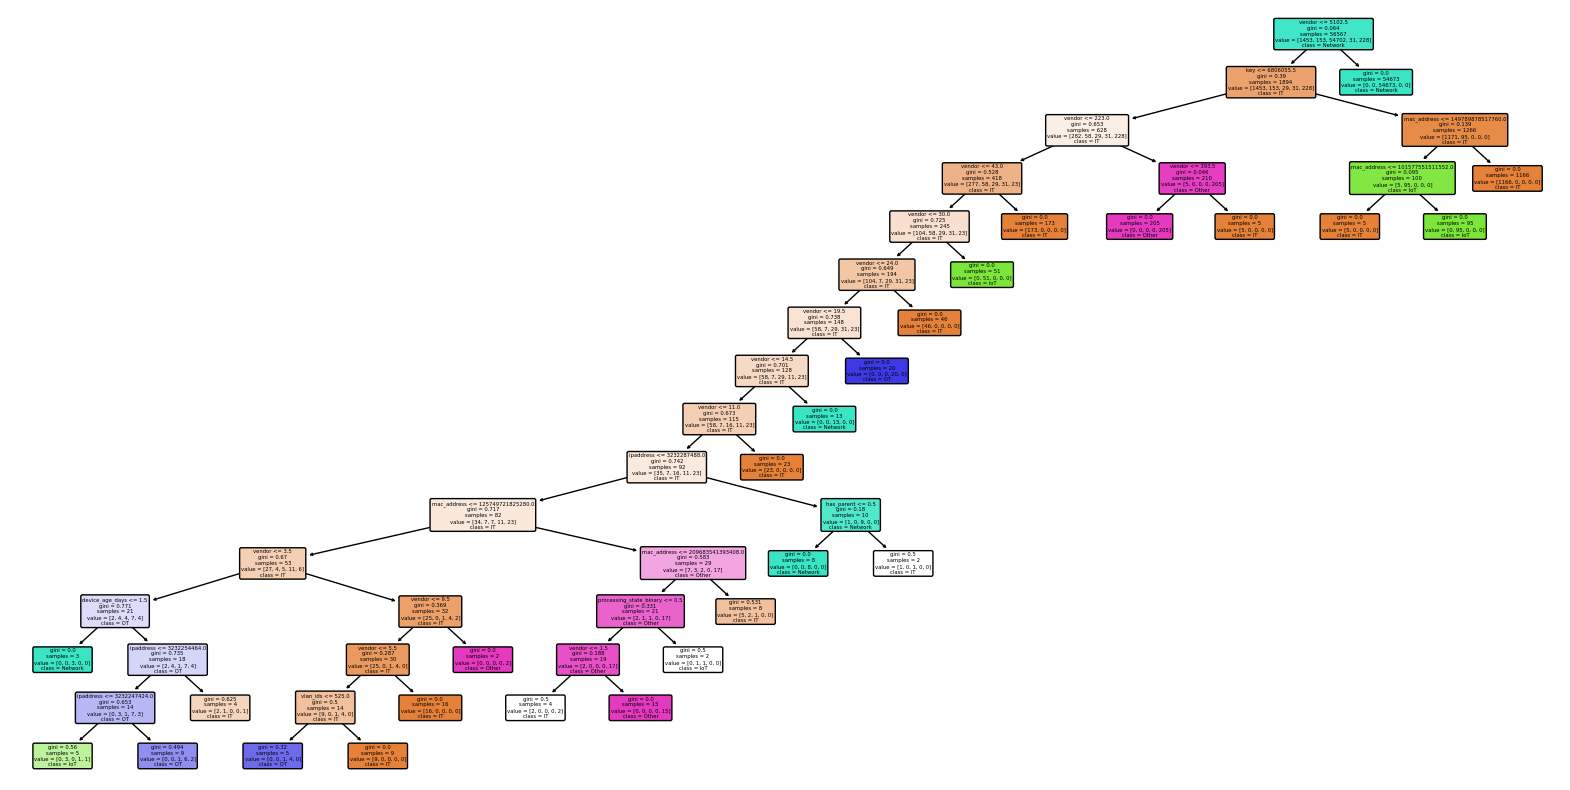

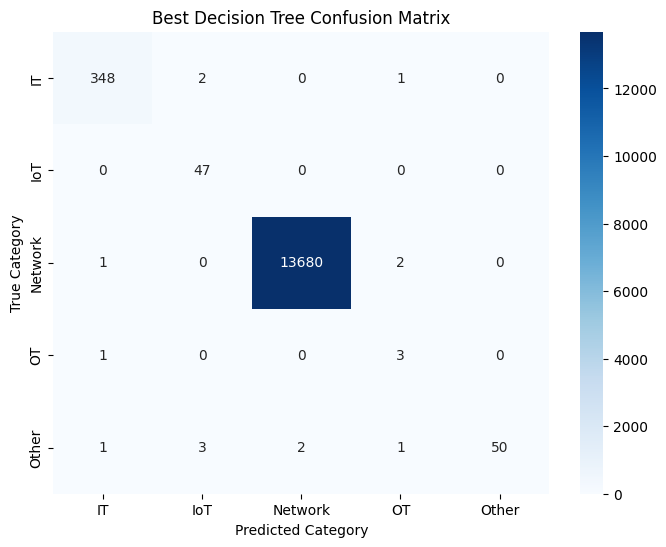

In [12]:
decisiontree_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + list(np.arange(2, 50, 2)),
    'min_samples_split':  list(np.arange(2, 15, 2)),
    'min_samples_leaf': list(np.arange(1, 5)),
    'max_features': [None, 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=tree, param_grid=decisiontree_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_tree = grid_search.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)
print(classification_report(y_test, y_pred_best_tree, target_names=label_encoder.classes_))
feature_importances_best_tree = best_tree.feature_importances_
importance_df_best_tree = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_best_tree})
importance_df_best_tree = importance_df_best_tree.sort_values(by='Importance', ascending=False)
#Feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_best_tree)
plt.title('Feature Importance (Best Decision Tree)')
plt.show()
#Tree graph
plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=label_encoder.classes_, rounded=True)
plt.show()
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Best Decision Tree Confusion Matrix")
plt.show()


In [13]:
# GridSearchCV optimal tree Backend network results
pred_foreign = best_tree.predict(X_foreign)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.48      0.58      0.53       270
         IoT       0.02      0.06      0.03        33
     Network       1.00      1.00      1.00     68015
          OT       0.08      0.10      0.09        52
       Other       0.26      0.07      0.11       192

    accuracy                           0.99     68562
   macro avg       0.37      0.36      0.35     68562
weighted avg       0.99      0.99      0.99     68562



#DECSION TREE WITH SMOTE OVERSAMPLING

In [14]:
# Definition of smote model and oversampling
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       351
           1       0.90      0.98      0.94        47
           2       1.00      1.00      1.00     13683
           3       1.00      0.50      0.67         4
           4       0.95      0.93      0.94        57

    accuracy                           1.00     14142
   macro avg       0.97      0.88      0.91     14142
weighted avg       1.00      1.00      1.00     14142



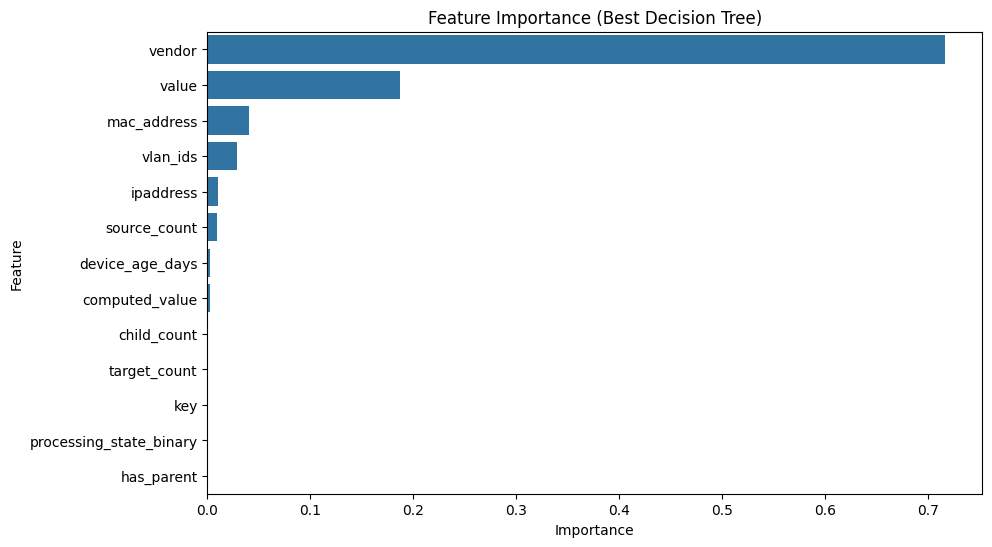

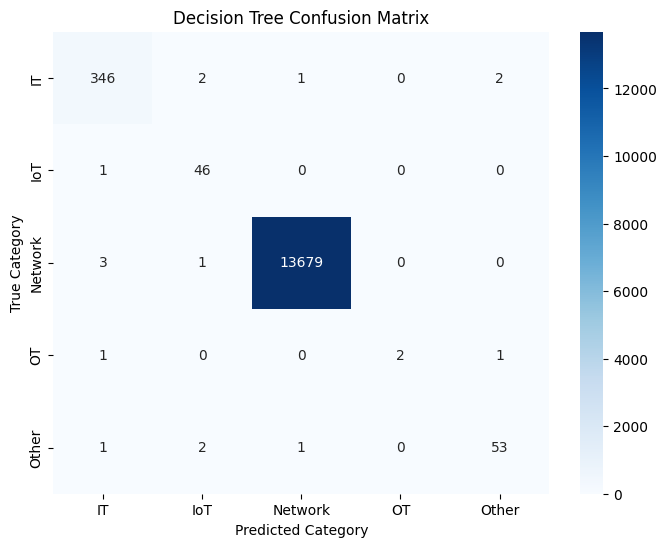

In [15]:

# Decision Tree trained on oversampled data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_oversampled, y_train_oversampled)
feature_names = X.columns
y_pred_oversampled = dt_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred_oversampled))
#Feature importance
feature_importances_best_tree = dt_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_best_tree})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Best Decision Tree)')
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_oversampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [16]:
# SMOTE Decision Tree performance on Backend Network
pred_foreign = dt_model.predict(X_foreign)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.64      0.85      0.73       270
         IoT       0.59      0.67      0.63        33
     Network       1.00      1.00      1.00     68015
          OT       0.27      0.06      0.10        52
       Other       0.67      0.47      0.55       192

    accuracy                           1.00     68562
   macro avg       0.64      0.61      0.60     68562
weighted avg       1.00      1.00      1.00     68562



# DECISION TREE ON DATA WITH LABEL PROPAGATION APPLIED

In [17]:
def apply_label_propagation(data, kernel='knn', n_neighbors=4, alpha=None, model_type='propagation'):
    """
    Apply semi-supervised learning using label propagation or label spreading to classify unlabeled data.

    Parameters:
    ----------
    data : pandas.DataFrame
        A DataFrame containing both labeled and unlabeled data. It must include a 'category' column,
        where 0 indicates an unlabeled sample and non-zero values indicate labeled classes.

    kernel : str, default='knn'
        The kernel to use in the label propagation algorithm. Options include:
        - 'knn' (k-nearest neighbors)
        - 'rbf' (radial basis function)

    n_neighbors : int, default=4
        Number of neighbors to use for the kernel when `kernel='knn'`.

    alpha : float or None, default=None
        Clamping factor for the LabelSpreading model (ignored if using LabelPropagation). If None,
        defaults to 0.2 when `model_type='spreading'`.

    model_type : str, default='propagation'
        The type of model to use:
        - 'propagation' for LabelPropagation
        - 'spreading' for LabelSpreading

    Returns:
    -------
    pandas.DataFrame
        A copy of the original DataFrame with the 'category' column updated, where previously unlabeled
        (category == 0) samples are now assigned predicted labels.

    Raises:
    ------
    ValueError
        If an invalid `model_type` is provided (must be 'propagation' or 'spreading').

    Notes:
    -----
    This function assumes the features are numeric and suitable for use with scikit-learn's
    LabelPropagation/LabelSpreading models.
    """
    labeled_data = data[data['category'] != 0]
    unlabeled_data = data[data['category'] == 0]
    X_labeled = labeled_data.drop(columns=['category'])
    y_labeled = labeled_data['category']
    X_unlabeled = unlabeled_data.drop(columns=['category'])
    if model_type == 'propagation':
        model = LabelPropagation(kernel=kernel, n_neighbors=n_neighbors)
    elif model_type == 'spreading':
        model = LabelSpreading(
            kernel=kernel, n_neighbors=n_neighbors, alpha=alpha or 0.2)
    else:
        raise ValueError(
            "Invalid model_type. Choose 'propagation' or 'spreading'.")
    model.fit(X_labeled, y_labeled)
    predicted_labels = model.predict(X_unlabeled)
    updated_data = data.copy()
    updated_data.loc[updated_data['category']
                     == 0, 'category'] = predicted_labels
    return updated_data

In [18]:
# Creation of Label Propagated Data (Swiss Tools)
swiss_types = my_read_fn("swiss_types")
swiss_asset = my_read_fn("swiss_asset")
swiss_asset = swiss_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
swiss_asset['asset_type_id'] = swiss_asset['asset_type_id'].fillna(0)
swiss_asset['processing_state_binary'] = swiss_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
swiss_asset = swiss_asset.drop(columns=['processing_state'])
swiss_asset['ipaddress'] = swiss_asset['ipaddress'].apply(network_to_int)
swiss_asset['mac_address'] = swiss_asset['mac_address'].apply(mac_to_int)
swiss_asset['vlan_ids'] = swiss_asset['vlan_ids'].apply(extract_first_vlan)
swiss_asset['date_created'] = pd.to_datetime(swiss_asset['date_created'], utc=True).dt.tz_convert('UTC')
swiss_asset['date_updated'] = pd.to_datetime(swiss_asset['date_updated'], utc=True).dt.tz_convert('UTC')
swiss_asset['device_age_days'] = (swiss_asset['date_updated'] - swiss_asset['date_created']).dt.days
swiss_asset = swiss_asset.drop(columns=['date_created','date_updated','last_reported'])
swiss_types = swiss_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
df_propagated = swiss_asset.merge(swiss_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
df_propagated.fillna(0, inplace=True)
df_propagated = df_propagated.drop(columns=['id_type'])
df_propagated = df_propagated.merge(swiss_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
df_propagated['value'] = df_propagated['value'].fillna(0)
source_counts = swiss_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = swiss_relations['target_asset_id'].value_counts().rename('target_count')
df_propagated['source_count'] = df_propagated['id'].map(source_counts).fillna(0).astype(int)
df_propagated['target_count'] = df_propagated['id'].map(target_counts).fillna(0).astype(int)
df_propagated = df_propagated.drop(columns=['asset_id', 'id_prop'], errors='ignore')
child_counts = df_propagated['parent_asset_id'].value_counts().rename('child_count')
df_propagated['child_count'] = df_propagated['id'].map(child_counts).fillna(0).astype(int)
df_propagated['has_parent'] = df_propagated['parent_asset_id'].notna().astype(int)
vendor_counts = df_propagated['vendor'].value_counts()
df_propagated['vendor'] = df_propagated['vendor'].map(vendor_counts)
df_propagated = df_propagated.drop(columns=['parent_asset_id', 'id', 'asset_type_id'], errors='ignore')
df_propagated = df_propagated.fillna(0)
df_propagated['category'] = df_propagated['category'].fillna(0)
data_ = df_propagated

In [19]:
# Labelled and unlabelled counts
df_propagated['category'].value_counts()

category
0          159882
Network     68385
IT           1804
Other         285
IoT           200
OT             35
Name: count, dtype: int64

In [20]:
# Apply Label Propagation
result1 = apply_label_propagation(data_, kernel='knn', n_neighbors=4, model_type='propagation')
#result2 = apply_label_propagation(data_, kernel='knn', n_neighbors=6, alpha=0.5, model_type='spreading')
#print(result2)
print(result1)
data_ = result1

         ipaddress   mac_address  computed_value  vlan_ids  \
0        301824712  3.890695e+10               0        45   
1        996114500  2.642007e+14               0      1001   
2       3232261888  3.890695e+10               1      2102   
3       3080766095  2.642007e+14               0      1001   
4        454662365  2.642007e+14               0      1001   
...            ...           ...             ...       ...   
230586  2121152450  2.642007e+14               0      1001   
230587   586807333  3.890695e+10               0        45   
230588  3304807474  2.642007e+14               0      1001   
230589  3300877869  2.642007e+14               0      1001   
230590   917207578  6.160310e+13               0      1007   

        processing_state_binary  device_age_days category  vendor  key  value  \
0                             1                0  Network  159882  0.0    0.0   
1                             1                0  Network  159882  0.0    0.0   
2           

In [21]:
# Encoding propagated 'category'
data_['category_encoded'] = label_encoder.fit_transform(data_['category'])
data_ = data_.drop(columns=['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

In [22]:
data_['id'] = swiss_asset['id']
data = df.drop(columns=['parent_asset_id','asset_type_id']).fillna(0)
data_ = data_[~data_['id'].isin(data['id'])]
#data_filtered
data_ = data_.drop(columns=['id'])

In [23]:
# Label Propagated Data train/test split
Xl = data_.drop(columns=['category_encoded'])
yl = data_['category_encoded']
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, test_size=0.2, random_state=42, stratify=yl)
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(Xl_train, yl_train)
y_predl = dtree.predict(X_test)
print(classification_report(y_test, y_predl))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       351
           1       1.00      0.96      0.98        47
           2       1.00      1.00      1.00     13683
           3       1.00      1.00      1.00         4
           4       0.94      0.89      0.92        57

    accuracy                           1.00     14142
   macro avg       0.98      0.97      0.98     14142
weighted avg       1.00      1.00      1.00     14142



In [24]:
# Label propagation performance on Backend Network:
pred_foreign = dtree.predict(X_foreign)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.49      0.65      0.56       270
         IoT       0.00      0.00      0.00        33
     Network       1.00      1.00      1.00     68015
          OT       0.00      0.00      0.00        52
       Other       0.38      0.11      0.17       192

    accuracy                           0.99     68562
   macro avg       0.38      0.35      0.35     68562
weighted avg       0.99      0.99      0.99     68562



In [25]:
# Finding misclassified assets
misclassified_indices = X_test.index[y_test != y_predl]
# Retrieve misclassified rows and corresponding predictions
misclassified_rows = X_test.loc[misclassified_indices]
true_labels = y_test.loc[misclassified_indices]
predicted_labels = pd.Series(y_predl, index=X_test.index).loc[misclassified_indices]
# Combine for easier viewing
misclassified_df = misclassified_rows.copy()
misclassified_df['true_label'] = true_labels
misclassified_df['predicted_label'] = predicted_labels
# Show the first few misclassified rows
misclassified_df.head()

,ipaddress,mac_address,computed_value,vlan_ids,processing_state_binary,device_age_days,vendor,key,value,source_count,target_count,child_count,has_parent,true_label,predicted_label
18917,3232261632,5.721841e+13,1045,0,0,40,4,0.0,0.0,517,507,3,0,2,4
8171,3232261120,8.393600e+13,0,1001,0,0,1,0.0,0.0,3,0,0,0,4,0
67959,3232261632,1.540665e+14,18,2102,1,3,10,0.0,0.0,61,59,0,0,4,0
66121,2469228713,4.160846e+11,0,1001,1,0,4,0.0,0.0,0,1,1,0,0,2
53229,3649078229,2.642007e+14,0,1001,1,26,18321,0.0,0.0,0,1,0,1,2,0


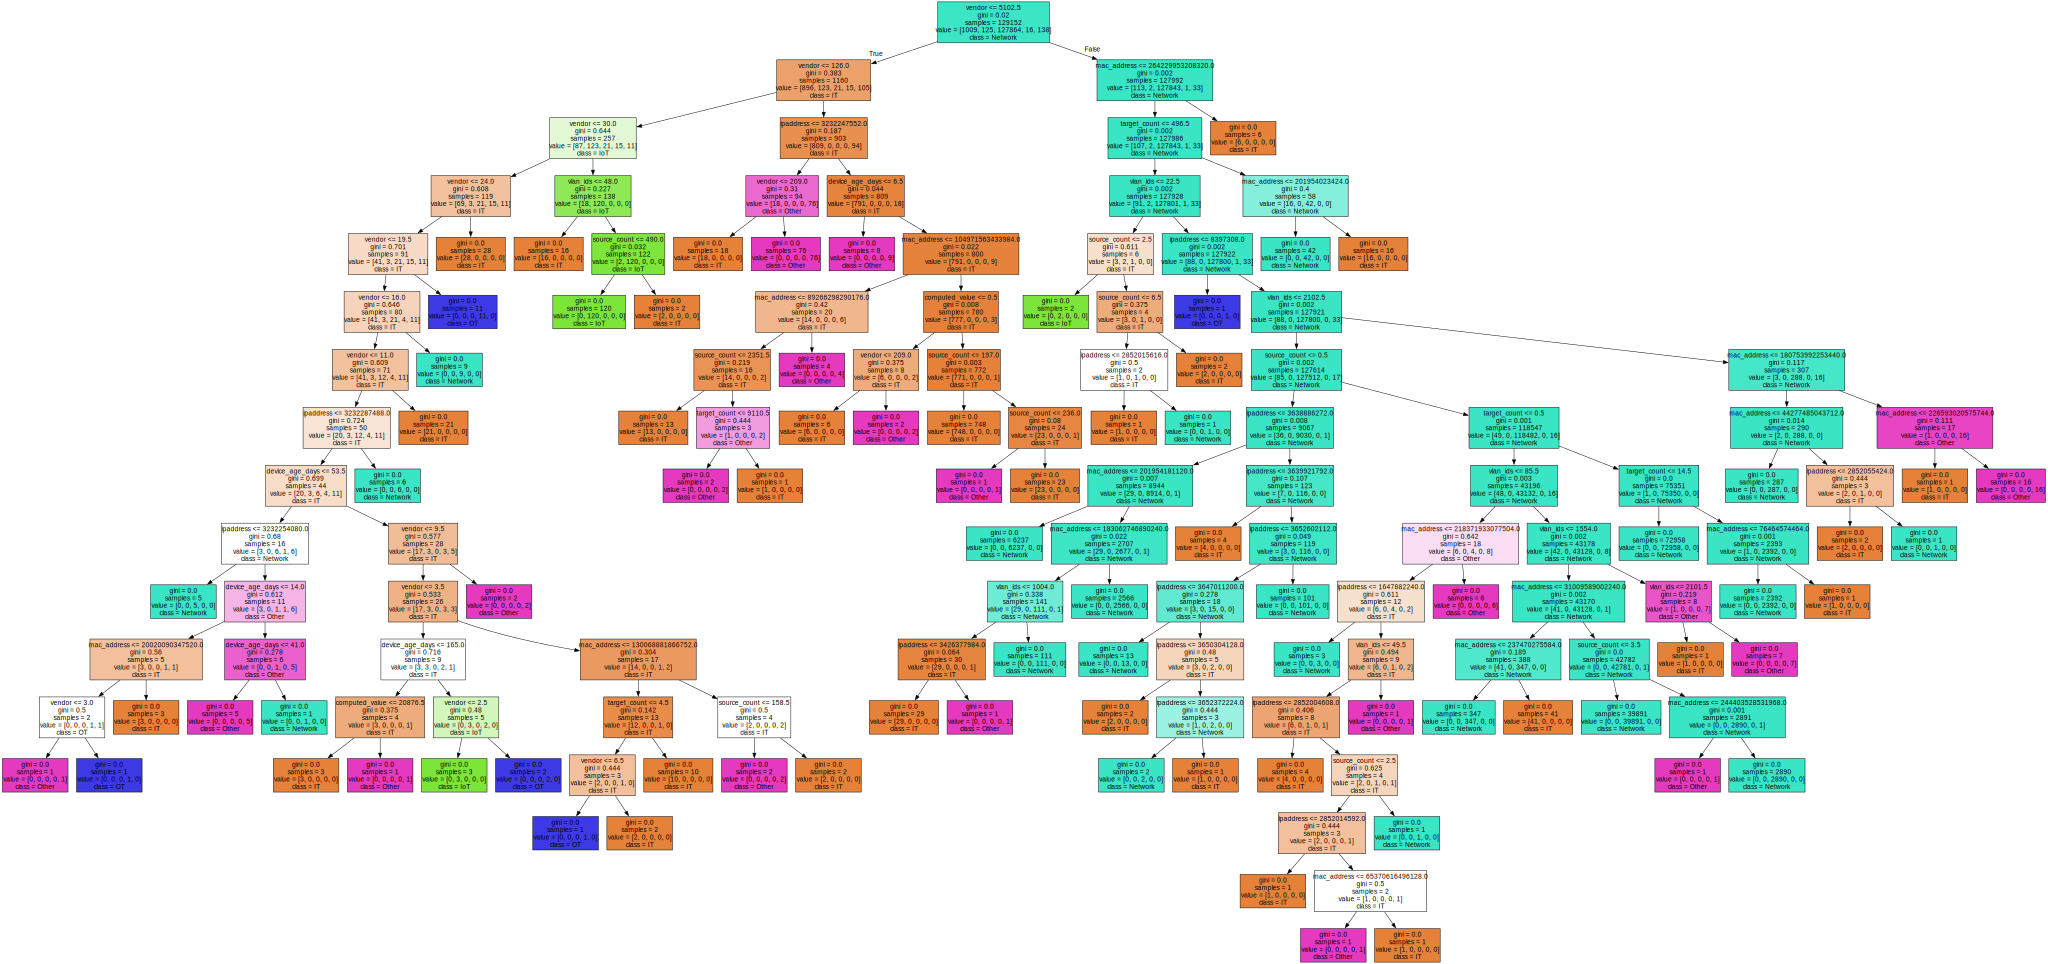

In [26]:
# Scrollable visualization of a Label Propagation Decision Tree
export_graphviz(dtree,
                out_file="dtree.dot",
                feature_names=X.columns,
                class_names=label_encoder.classes_,
                filled=True)
from graphviz import Source

with open("dtree.dot") as f:
    dot_graph = f.read()

Source(dot_graph)

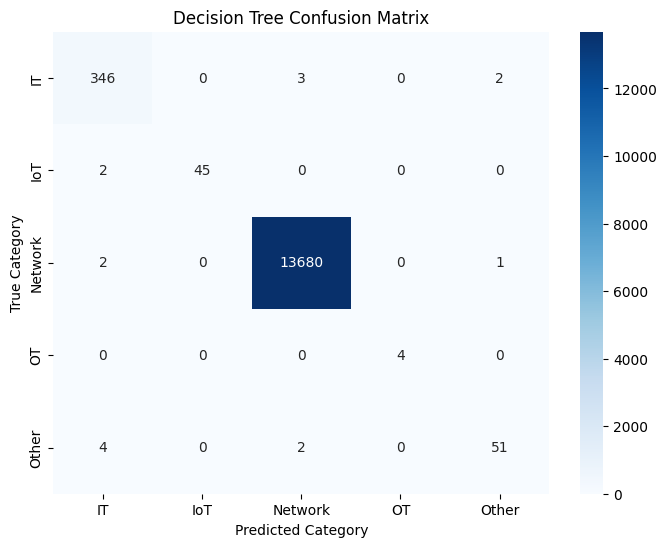

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Decision Tree Confusion Matrix")
plt.show()

#DECISION TREE WITH RANDOM SAMPLE TO MANAGE CLASS IMBALANCE

In [28]:
# Sampling and Encoding of sampled data
data = df.drop(columns=['parent_asset_id','id','asset_type_id']).fillna(0)
network_sample = data[data['category'] == 'Network'].sample(n=300, random_state=42)
it_sample = data[data['category'] == 'IT'].sample(n=300, random_state=42)
other_data = data[~data['category'].isin(['Network', 'IT'])]
data_sample = pd.concat([other_data, network_sample, it_sample], ignore_index=True)
data_sample['category_encoded'] = label_encoder.fit_transform(data_sample['category'])
data_sample = data_sample.drop(columns=['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

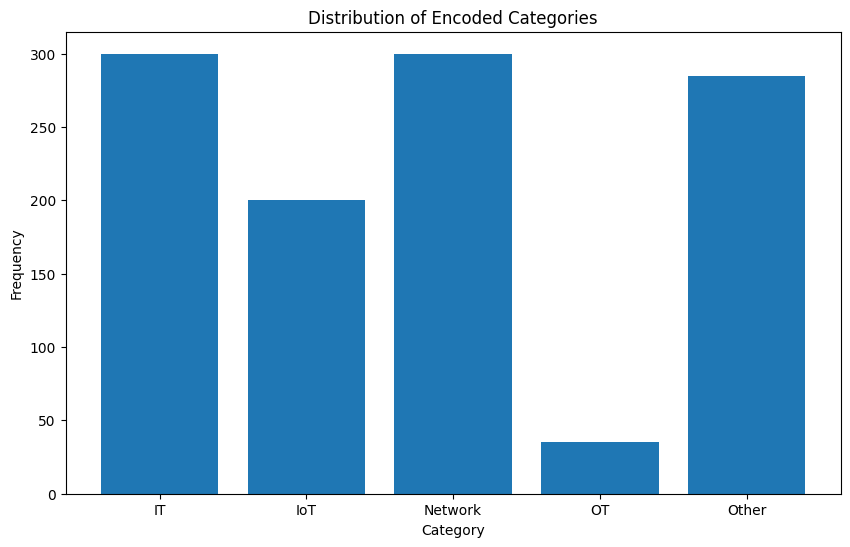

In [29]:
# Sample Data category class distribution
plt.figure(figsize=(10, 6))
plt.hist(data_sample['category_encoded'], bins=range(len(label_encoder.classes_) + 1), align='left', rwidth=0.8)
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Encoded Categories')
plt.show()

In [30]:
# Decision Tree Training on a Sampled Dataset
#data_sample=data_sample.drop(columns=['id'])
X_sample = data_sample.drop(columns=['category_encoded'])
y_sample = data_sample['category_encoded']
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_sample = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_sample))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       351
           1       0.94      1.00      0.97        47
           2       1.00      1.00      1.00     13683
           3       0.60      0.75      0.67         4
           4       0.98      0.89      0.94        57

    accuracy                           1.00     14142
   macro avg       0.90      0.93      0.91     14142
weighted avg       1.00      1.00      1.00     14142



In [31]:
# Sample Data Decision Tree Backend Performance
pred_foreign = model.predict(X_foreign)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.48      0.57      0.52       270
         IoT       0.02      0.06      0.03        33
     Network       1.00      1.00      1.00     68015
          OT       0.11      0.12      0.11        52
       Other       0.26      0.08      0.12       192

    accuracy                           0.99     68562
   macro avg       0.37      0.36      0.36     68562
weighted avg       0.99      0.99      0.99     68562



# FURTHER TESTS AFTER INITIAL TRAININGS

In [32]:
# Label Propagadated Decision Tree model with removed "vendor" variable
Xl_no_vendor = data_.drop(columns=['category_encoded', 'vendor'])
yl = data_['category_encoded']

# Train/test split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    Xl_no_vendor, yl, test_size=0.2, random_state=42, stratify=yl
)
# Train Decision Tree
dtree_ = DecisionTreeClassifier(random_state=42)
dtree_.fit(Xl_train, yl_train)
X_test_ = X_test.drop(columns=['vendor'])
# Predict and evaluate
yl_pred = dtree_.predict(X_test_)
print(classification_report(y_test, yl_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       351
           1       0.91      0.91      0.91        47
           2       1.00      1.00      1.00     13683
           3       0.80      1.00      0.89         4
           4       0.74      0.65      0.69        57

    accuracy                           1.00     14142
   macro avg       0.88      0.91      0.89     14142
weighted avg       1.00      1.00      1.00     14142



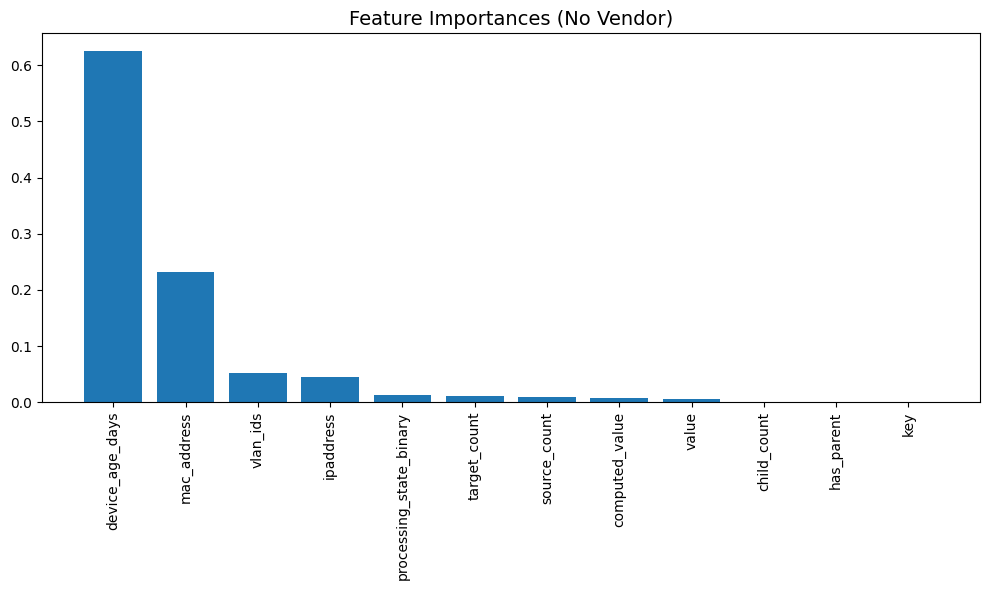

In [33]:
# Feature Importance for Label Propagated Decision Tree - no 'vendor'
importances = dtree_.feature_importances_
feature_names = Xl_no_vendor.columns
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (No Vendor)", fontsize=14)
plt.bar(range(len(importances)), sorted_importances, align="center")
plt.xticks(range(len(importances)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

In [34]:
# Label Propagation Performance on Backend - no 'vendor'
X_foreign_ = X_foreign.drop(columns=['vendor'])
pred_foreign = dtree_.predict(X_foreign_)
basic_decision_tree = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_decision_tree)

              precision    recall  f1-score   support

          IT       0.02      0.80      0.04       270
         IoT       0.33      0.36      0.35        33
     Network       1.00      0.86      0.92     68015
          OT       0.81      0.40      0.54        52
       Other       0.71      0.45      0.55       192

    accuracy                           0.86     68562
   macro avg       0.57      0.58      0.48     68562
weighted avg       0.99      0.86      0.92     68562

